In [2]:
import argparse
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
from joblib import Parallel, delayed
from collections import OrderedDict
import matplotlib.pyplot as plt
from utilities.meta_utils import tensors_to_device


from learner.BasicLearner import BasicLearner
from learner.WrapperLearner import WrapperLearner
from network.meta_network import MetaNetworkWithPertubation, NoisyMetaNetwork, MetaContainer
from task.TaskGenerator import SinTaskGenerator
from utilities.folder_management import handle_folder_creation


In [3]:
def plot(task_generator, amplitude_list, phase_list, model, perturbation=False, p_iter=5,
        plot_true=False, legend=False, plot_res=False):
    x_points = task_generator.x_space
    
    if plot_true:
        i = 0
        for a, p in zip(amplitude_list, phase_list):
            y_points = a * torch.sin(x_points - p)
            plt.plot(x_points[0], y_points[0], label="Task {}".format(i))
            i += 1
    
    if perturbation:
        for i in range(0, p_iter):
            if plot_res:
                y = model(task_generator.x_space[0].unsqueeze(1), perturbation=True).detach()
                y -= model(task_generator.x_space[0].unsqueeze(1), perturbation=False).detach()
            else:
                y = model(task_generator.x_space[0].unsqueeze(1), perturbation=perturbation).detach()
            plt.plot(x_points[0],y, label="Net {}".format(i))
    else:
        plt.plot(x_points[0], model(task_generator.x_space[0].unsqueeze(1), perturbation=perturbation).detach(), label="Net")
    
    if legend:
        plt.legend()
    plt.show()

In [4]:
def plot_model_list(task_generator, amplitude_list, phase_list, model_list, plot_true=False):
    x_points = task_generator.x_space
    
    if plot_true:
        i = 0
        for a, p in zip(amplitude_list, phase_list):
            y_points = a * torch.sin(x_points - p)
            plt.plot(x_points[0], y_points[0], label="Task {}".format(i))
            i += 1
    
    for i in range(len(model_list)):
        plt.plot(x_points[0], model_list[i](task_generator.x_space[0].unsqueeze(1)).detach(), label="Net {}".format(i))
    
    plt.legend()
    plt.show()

In [5]:
# Network parameters
INPUT_SIZE = 1
OUTPUT_SIZE = 1
HIDDEN_SIZE = (64, 64, 64)

TRAINING_EPOCHS = 10
TEST_PERCENTAGE = 0.2

NET_LR = 0.01

# Meta parameters
FIRST_ORDER = False
RES_STOCHASTIC_ITERATION = 30
RES_LR = 0.001

# Dataset parameters
MIN_X = -5
MAX_X = 5

BATCH_SIZE = 128
LATER_BATCH_SIZE = 10

NUM_BATCH_FIRST_TASK = 1000
NUM_BATCH_LATER_TASK = 5

MAX_BATCHES_FIRST_TASK = 2000
MAX_BATCHES_LATER_TASK = 30

SIMULATE_MAX_BATCHES = 1000
SIMULATE_BATCH_SIZE = 32
SIMULATE_N_BATCHES = 250
SIMULATE_TEST_SPLIT = 0.2

# Task parameters
AMPLITUDE_LIST = [1, 1.4, 1.8, 2.2, 2.8, 3.2, 3.6, 4.0, 4.4, 4.0, 3.6, 3.2, 3.6, 3.2, 3.2, 2.8]
PHASE_LIST = [0, 0.3, 0.6, 0.8, 1.0, 1.3, 1.6, 1.3, 1.6, 1.3, 1.0, 1.5, 1.8, 1.4, 1.5, 1.3]
n_tasks = len(AMPLITUDE_LIST)

In [6]:
task_generator: SinTaskGenerator = SinTaskGenerator(x_min=MIN_X, x_max=MAX_X)
device = "cpu"

init_mean_w_output = torch.zeros(HIDDEN_SIZE[-1], device=device)
init_std_w_output = 0.1*torch.ones(HIDDEN_SIZE[-1], device=device)
init_mean_b_output = torch.zeros(OUTPUT_SIZE, device=device)
init_std_b_output = 0.1*torch.ones(OUTPUT_SIZE, device=device)

init_mean_w_input = torch.zeros(HIDDEN_SIZE[0], device=device)
init_std_w_input = 0.1*torch.ones(HIDDEN_SIZE[0], device=device)
init_mean_b_input = torch.zeros(HIDDEN_SIZE[0], device=device)
init_std_b_input = 0.1*torch.ones(HIDDEN_SIZE[0], device=device)

init_input_mean = torch.zeros(1, device=device)
init_input_std = 0.3 * torch.ones(1, device=device)

task_0_net: torch.nn.Module = MetaContainer(n_in=INPUT_SIZE, n_out=OUTPUT_SIZE, hidden_sizes=HIDDEN_SIZE,
                                               init_mean_w_output=init_mean_w_output, 
                                               init_std_w_output=init_std_w_output,
                                               init_mean_b_output=init_mean_b_output, 
                                               init_std_b_output=init_std_b_output,
                                               init_mean_w_input=init_mean_w_input.unsqueeze(1), 
                                               init_std_w_input=init_std_w_input.unsqueeze(1),
                                               init_mean_b_input=init_std_b_input,
                                               init_std_b_input=init_std_b_input,
                                               new_space_size=5,
                                               w_init=0.5,
                                               b_init=0.5
                                               )

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(task_0_net.parameters(), lr=0.01)
learner: WrapperLearner = WrapperLearner(network=task_0_net,
                                         n_in=INPUT_SIZE,
                                         n_out=OUTPUT_SIZE,
                                         optimizer=optimizer,
                                         loss_function=loss,
                                         scheduler=None,
                                         x_space=task_generator.x_space,
                                         device=device,
                                         first_order=FIRST_ORDER,
                                         learn_step_size=True)


In [7]:
# Train first model
task_0_net.set_learn_meta(False)
task_0_net.set_learn_net(True)
data_loader_task_0 = task_generator.get_data_loader(amplitude=AMPLITUDE_LIST[0], test_perc=0,phase=PHASE_LIST[0], num_batches=3000, batch_size=128)
learner.train(data_loader_task_0, 5000)

5001it [00:34, 146.68it/s, loss=0.0130]                          


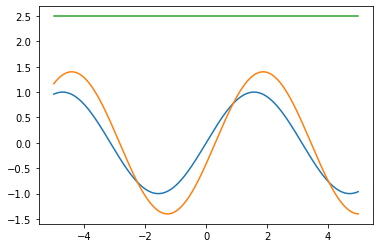

In [15]:
learner.network.activate_meta=True
plot(task_generator,  AMPLITUDE_LIST[0:2], PHASE_LIST[0:2], learner.network, perturbation=False, p_iter=100,
        plot_true=True, legend=False, plot_res=False)

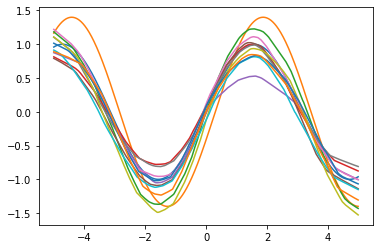

In [9]:
plot(task_generator,  AMPLITUDE_LIST[0:2], PHASE_LIST[0:2], learner.network, perturbation=True, p_iter=10,
        plot_true=True, legend=False, plot_res=False)

In [10]:
new_optim = torch.optim.Adam(learner.network.parameters(), lr=0.01)
learner.reset_optimizer(new_optim)
learner.simulate_meta_training(num_batches=300, batch_size=128, test_split=0.1, max_batches=5000, first_task=True)

5001it [03:58, 20.97it/s, loss=0.6518]                          


In [11]:
OrderedDict(learner.network.named_meta_parameters())['meta_out_2.weight']

Parameter containing:
tensor([[ 9.2116e-04, -1.4061e-04, -2.1779e-01,  2.5894e-04,  2.8915e-05]],
       requires_grad=True)

In [12]:
OrderedDict(learner.network.named_meta_parameters())['layer1.weight'][0:10]

tensor([[-0.3962],
        [-0.0006],
        [-0.4644],
        [ 0.5031],
        [ 0.0020],
        [ 0.2794],
        [ 0.3181],
        [ 0.5178],
        [-0.0406],
        [-0.2809]])

In [13]:
learner.simulate_meta_training(num_batches=2000, batch_size=128, test_split=0.1, max_batches=15000, first_task=True)

15001it [11:54, 20.99it/s, loss=0.9523]                           


In [18]:
OrderedDict(learner.network.named_meta_parameters())['meta_in_1.weight']

Parameter containing:
tensor([[-5.8541e-02],
        [-3.7856e-04],
        [ 1.8085e-01],
        [ 5.8854e-01],
        [ 2.4833e-03]], requires_grad=True)

In [24]:
OrderedDict(learner.network.named_meta_parameters())['layer1.weight'][0:10]

tensor([[-2.4258e-02],
        [-4.0550e-01],
        [-4.9650e-02],
        [ 4.0395e-04],
        [ 9.8653e-02],
        [ 3.2211e-03],
        [ 7.6492e-01],
        [ 7.0355e-01],
        [ 8.3033e-04],
        [-3.5185e-01]])